# Outline

[1. Establishing Goals](#1.-Establishing-Goals)

[2. Introduction to Dataset](#2.-Introduction-to-Dataset)

[3. Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)

[4. Limit Data to Scope](#4.-Limit-Data-to-Scope)

[5. Supervised Feature Generation](#5.-Supervised-Feature-Generation)
    
- [5.1 Common Bag of Words](#5.1-Common-Bag-of-Words)
- [5.2 Turn Common Words into Features](#5.2-Turn-Common-Words-into-Features)
- [5.3 Clustering on BOW](#5.3.-Clustering-on-BOW)
- [5.4 Classification on BOW](#5.4.-Classification-on-BOW)

[6. Unsupervised Feature Generation](#6.-Unsupervised-Feature-Generation)

- [6.1 Latent Semantic Analysis](#6.1.-Latent-Semantic-Analysis)
- [6.2 Clustering on LSA (BOW Content)](#6.2.-Clustering-on-LSA-(BOW-Content))
- [6.3 Classification on LSA (BOW Content)](#6.3.-Classification-on-LSA-(BOW-Content))
- [6.4 Clustering on LSA (All Content)](#6.4.-Clustering-on-LSA-(All-Content))
- [6.5 Classification on LSA (All Content)](#6.5.-Classification-on-LSA-(All-Content))

[7. Choosing Model](#7.-Choosing-Model)

- [7.1 Comparing Scores](#7.1.-Comparing-Scores)
- [7.2 Sorting by Test Accuracy](#7.2.-Sorting-by-Test_Accuracy)
- [7.3 Winner](#7.3.-Winner)

# 1. Establishing Goals

In this project I'll attempt to build models to correctly predict the author of a given article. The scope will be limited to 10 authors. The techniques I'll compare will include `Bag-of-Words` VS `Latent Semantic Analysis` for feature-generation, and `Clustering` VS `Supervised Learning` for classification. I'll also experiment with different sample sizes, as feature-generation can be very sensitive to high dimensionality.

# 2. Introduction to DataSet

**From:** https://www.kaggle.com/snapcrack/all-the-news

This dataset contains news articles scraped from various publications, labeled by publication and author name, as well as date and title.

The original source on `kaggle.com` contains three `.csv` files. Accross the three, there are over 140,000 articles from a total of 15 publications. 

The dataset used here is only the first of those three files, which contains about a third of all the data at roughly `280MB`. This is more than enough data for the goals of this project.

# 3. Exploratory Data Analysis

Let's get a quick overview of the data available.

In [1]:
# General-purpose Libraries
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import spacy
from time import time
%matplotlib inline

# Tools for processing data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score
# Classifiers, supervised and unsupervised
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read data into a DataFrame
data = pd.read_csv('articles2.csv')

In [3]:
# Preview the data
data.head(3)



,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,53293,73471,Patriots Day Is Best When It Digs Past the Her...,Atlantic,David Sims,2017-01-11,2017.0,1.0,NaN,"Patriots Day, Peter Berg’s new thriller that r..."
1,53294,73472,A Break in the Search for the Origin of Comple...,Atlantic,Ed Yong,2017-01-11,2017.0,1.0,NaN,"In Norse mythology, humans and our world were ..."
2,53295,73474,Obama’s Ingenious Mention of Atticus Finch,Atlantic,Spencer Kornhaber,2017-01-11,2017.0,1.0,NaN,“If our democracy is to work in this increasin...


**Checking for Missing Data**

- The content feature is complete. That's the most important thing. Some author names are missing. We'll make sure to choose 10 properly labeled.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   49999 non-null  int64  
 1   id           49999 non-null  int64  
 2   title        49998 non-null  object 
 3   publication  49999 non-null  object 
 4   author       41401 non-null  object 
 5   date         47373 non-null  object 
 6   year         47373 non-null  float64
 7   month        47373 non-null  float64
 8   url          42988 non-null  object 
 9   content      49999 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 3.8+ MB


**Length of Articles**
- In terms of number of characters, the average article has less than 4,000 letters.

Statistical Summary of Article Lengths
count     49999.000000
mean       4216.535491
std        5103.596233
min           2.000000
25%        1725.000000
50%        3199.000000
75%        5074.000000
max      164658.000000
dtype: float64


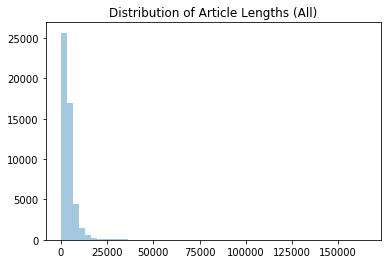

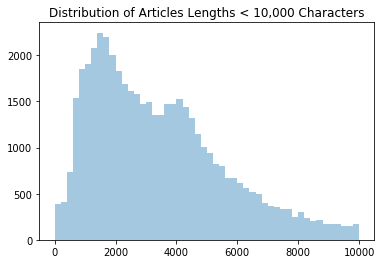

In [5]:
lengths = pd.Series([len(x) for x in data.content])
print('Statistical Summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths<10000],kde=False)
plt.title('Distribution of Articles Lengths < 10,000 Characters')
plt.show()

# 4. Limit Data to Scope
[Back to Outline](#Outline)

Here I'll pick the 10 authors whose names I'll predict based on their content. This selection will remain the same for all the methods I'll compare.

Since we only need 10 authors, I'll get the first 10 authors whose article-count is greater than X. 100 articles per author is a good number because more would take terribly long when fit to classifiers after `TF-IDF`. At the same time, `Bag-of-Words` is the slowest. However, for that I'll limit to 50 of these articles per author.

In [6]:
# First ten authors with more than X articles
print(data.author.value_counts()[data.author.value_counts()>100][-10:])

Lois Weiss             110
Todd Starnes           110
Emily Saul             109
Chris Geidner          109
Bourree Lam            106
James Fallows          106
Jaclyn Hendricks       105
Alexandra DeSanctis    105
Jamie Schram           104
Carleton English       103
Name: author, dtype: int64


In [7]:
# Make a DataFrame with articles by our chosen authors
# Include author names and article titles.

# Make a list of the 10 chosen author names
names = data.author.value_counts()[data.author.value_counts()>100][-10:].index.tolist()

# DataFrame for articles of all chosen authors
authors_data = pd.DataFrame()
for name in names:
    # Select each author's data
    articles = data[data.author==name][:100][['title','content','author']]
    # Append it to the DataFrame
    authors_data = authors_data.append(articles)

authors_data = authors_data.reset_index().drop('index',1)
    
authors_data.head()

,title,content,author
0,Here are the top real estate deals of 2016,Excitement has not been lacking in an industry...,Lois Weiss
1,Celebs losing beloved Plaza Hotel spa,The Plaza Hotel is losing its spa. The Plaza...,Lois Weiss
2,Brookfield Place is becoming a mecca for men’s...,"Downtown’s Brookfield Place, also owned by Bro...",Lois Weiss
3,Two new retailers setting up shop in Williamsburg,Two retailers are opening stores on Williamsbu...,Lois Weiss
4,245 Park Ave. poised to sell for over $2B,The first trophy office building of the year h...,Lois Weiss


In [8]:
# Look for duplicates
print('Number of articles:',authors_data.shape[0])
print('Unique articles:',len(np.unique(authors_data.index)))

# Number of authors
print('Unique authors:',len(np.unique(authors_data.author)))
print('')
print('Articles by author:\n')

# Articles counts by author
print(authors_data.author.value_counts())

Number of articles: 1000
Unique articles: 1000
Unique authors: 10

Articles by author:

Jaclyn Hendricks       100
Alexandra DeSanctis    100
Bourree Lam            100
James Fallows          100
Jamie Schram           100
Todd Starnes           100
Lois Weiss             100
Chris Geidner          100
Emily Saul             100
Carleton English       100
Name: author, dtype: int64


**Look at the Size of Articles Chosen**

Statistical Summary of Article Lengths
count     1000.000000
mean      6563.094000
std      12433.722696
min        107.000000
25%       1576.000000
50%       2659.000000
75%       4437.500000
max      87479.000000
dtype: float64


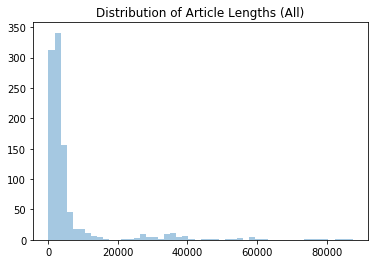

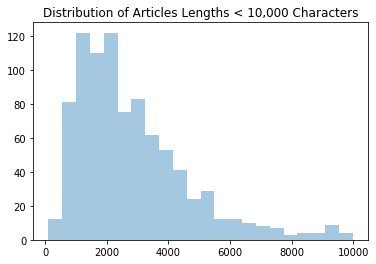

In [9]:
lengths = pd.Series([len(x) for x in authors_data.content])
print('Statistical Summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths<10000],kde=False)
plt.title('Distribution of Articles Lengths < 10,000 Characters')
plt.show()

# 5. Supervised Feature Generation
[Back to Outline](#Outline)

Bag of words is a list of the most common words of a given source of text. To identify each author, I'll create a bag of words containing the most-common words of all authors combined. This set later becomes the basis for feature engineering.

## 5.1 Common Bag of Words
- Here I'll extract the most-common 1000 words from each author's corpus, store them in a list, and then eliminate duplicates.

In [10]:
t0 = time()

# Load spacy NLP object
import spacy
nlp=spacy.load('en_core_web_sm')

# A list to store common words by all authors
common_words = []

# A dictionary to store the spacy_doc object of each author
authors_docs = {}

for name in names:
    # Corpus is all the text written by that author
    corpus = ""
    # Grab all rows of current author, along the 'content' column
    author_content = authors_data.loc[authors_data.author==name,'content']
    
    # Merge all articles in to the author's corpus
    for article in author_content:
        corpus = corpus + article
    # Let Spacy parse the author's body of text
    doc = nlp(corpus)
    
    # Store the doc in the dictionary
    authors_docs[name] = doc
        
    # Filter out punctuation and stop words.
    lemmas = [token.lemma_ for token in doc
                if not token.is_punct and not token.is_stop]
        
    # Return the most common words of that author's corpus.
    bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
    # Add them to the list of words by all authors.
    for word in bow:
        common_words.append(word)

# Eliminate duplicates
common_words = set(common_words)
    
print('Total number of common words:',len(common_words))
print("done in %0.3fs" % (time() - t0))

ValueError: [E088] Text of length 3745117 exceeds maximum of 1000000. The v2.x parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input. This means long texts may cause memory allocation errors. If you're not using the parser or NER, it's probably safe to increase the `nlp.max_length` limit. The limit is in number of characters, so you can check whether your inputs are too long by checking `len(text)`.

- From a theorical total of 10,000 common-words, (1,000 from 10 authors) 3,405 were unique. So roughly a third of all words used by each author is actually part of their unique style.

In [ ]:
# Let's see our 10 authors in the dictionary
lengths = []
for k,v in authors_docs.items():
    print(k,'corpus contains',len(v),' words.')
    lengths.append(len(v))

In [ ]:
sns.barplot(x=lengths,y=names,orient='h')
plt.title('Word Count per Author in Chosen Data')
plt.show()

## 5.2 Turn Common Words into Features

**Approach**

Due to the curse of dimensionality, doing this step with all our 1,000 articles would take prohibitively long. (10 authors * 100 articles/ea = 1,000 articles)  At 30 seconds per article, my personal machine would need 8.5 hours of processing. Therefore I'll limit this part to 50 articles per author. This should still convey enough information for a decent predictive model.

**About 'Common Bag of Words'**

This technique consists of creating a feature out of each common word and then counting the number of times each common word appears in each article. Each cell will represent the number of times the lemma of the given column appears in the article of the current row. We have over 3,000 common words, and will be using 500 articles total. (50 per author) Plus each article may have a varying number of words in it. That's a lot of text to compare and count.

In [ ]:
# check for lower case words
common_words = pd.Series(pd.DataFrame(columns=common_words).columns)
print('Count of all common_words:',len(common_words))
print('Count of lowercase common_words:',np.sum([word.islower() for word in common_words]))

# Turn all common_words into lower case
common_words = [word.lower() for word in common_words]
print('Count of lowercase common_words (After Conversion):',np.sum([word.islower() for word in common_words]))

- Notice that after converting to lowercase the total number of lowercase words still isn't the same as the total. This means there are around 100 non alphabetic words inside our bag. This is probably made up of numbers and words with punctuations within.



In [ ]:
# We must remove these in to avoid conflicts with existing features.
if 'author' in common_words:
    common_words.remove('author')
if 'title' in common_words:
    common_words.remove('title')
if 'content' in common_words:
    common_words.remove('content')

In [ ]:
# Count the number of times a common_word appears in each article
# (about 3Hrs processing)

bow_counts = pd.DataFrame()
for name in names:
    # Select X articles of that author
    articles = authors_data.loc[authors_data.author==name,:][:50]
    bow_counts = bow_counts.append(articles)
bow_counts = bow_counts.reset_index().drop('index',1)

# Use common_words as the columns of a temporary DataFrame
df = pd.DataFrame(columns=common_words)

# Join BOW features with the author's content
bow_counts = bow_counts.join(df)

# Initialize rows with zeroes
bow_counts.loc[:,common_words] = 0

# Fill the DataFrame with counts of each feature in each article
t0 = time()
for i, article in enumerate(bow_counts.content):
    doc = nlp(article)
    for token in doc:
        if token.lemma_.lower() in common_words:
            bow_counts.loc[i,token.lemma_.lower()] += 1
    # Print a message every X articles
    if i % 50 == 0:
        if time()-t0 < 3600: # if less than an hour in seconds
            print("Article ",i," done after ",(time()-t0)/60,' minutes.')
        else:
            print("Article ",i," done after ",(time()-t0)/60/60,' hours.')

- This is the data that we can use to train clusters and classifiers. Each entry is an article, each column is a common word, and each cell is a count of the current common word in the current article.

In [ ]:
bow_counts.head(3)

**Optional:**

- Store contents of `bow_counts`

In [ ]:
# This saves the long-awaited data into a pickle file for easy recovery
#bow_counts.to_pickle('bow_counts')

# Read it back in with the following
#bow_counts = pd.read_pickle('bow_counts')

In [ ]:
# Make sure we have 50 articles per author
bow_counts.author.value_counts()

## 5.3. Clustering on BOW

[Back to Outline](#Outline)

- Before classifying, I'll start with clustering. Here I'll create clusters out of the BOW data and see if those clusters resemble the actual author's content. Clusters have no labels, but similar content tends to fall into the same clusters. Therefore in an ideal clustering solution, each author's articles would all fall into a single cluster.

In [ ]:
# Establish outcome and predictors
y = bow_counts['author']
X = bow_counts.drop(['content','author','title'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.24,
                                                    random_state=0,
                                                    stratify=y)

In [ ]:
# Make sure classes are balanced after train-test-split
y_test.value_counts()

**DataFrame to Store our Results**

This `DataFrame` will hold results from all algorithms implemented ahead. For clustering algorithms, the train/test and cross_val columns will be left blank because clustering requires no train/test split. On the other hand, classifiers will inded store their own `ARI, Homogeneity, Silhouette, and Mutual_Info` scores. `Features` will represent the method for feature-engineering, whether BOW or LSA. And the `n_train` column will represent the number of samples in the train size.

In [ ]:
# Store our results in a DataFrame
metrics = ['Algorithm','n_train','Features','ARI','Homogeneity',
           'Silhouette','Mutual_Info','Cross_Val','Train_Accuracy',
           'Test_Accuracy']
performance = pd.DataFrame(columns=metrics)

**Approach to Clustering**

In cluster analysis, there usually is no training or test data split. Because you do cluster analysis when you do not have labels, so you cannot "train".Training is a concept from machine learning, and train-test splitting is used to avoid overfitting. But if you are not learning labels, you cannot overfit. Properly used cluster analysis is a knowledge discovery method. You want to discover some new structure in your data, not rediscover something that is already labeled.

### 5.3.1. Unsupervised Parameter Search Function

[Back to Outline](#Outline)

- This function will find the parameters that produce the highest `Normalized Mutual Infomation` score from our clusters. This score is a good baseline from which to compare clustering VS classification because it correlates with good clutering as well as higher accuracy scores.
- It'll print the relevant statistics as well as a contingency matrix of the result and lastly store our results in an external DataFrame.

In [ ]:
# Function to quickly evaluate clustering solutions
def evaluate_clust(clust,params,features,i):
    t0 = time()
    print('\n','-'*40,'\n',clust.__class__.__name__,'\n','-'*40)
    
    # Find best parameters based on scoring of choice
    score = make_scorer(normalized_mutual_info_score)
    search = GridSearchCV(clust,params,scoring=score,cv=3).fit(X,y)
    print("Best parameters:",search.best_params_)
    y_pred = search.best_estimator_.fit_predict(X)

    ari = adjusted_rand_score(y, y_pred)
    performance.loc[i,'ARI'] = ari 
    print("Adjusted Rand-Index: %.3f" % ari)
    
    hom = homogeneity_score(y,y_pred)
    performance.loc[i,'Homogeneity'] = hom
    print("Homogeneity Score: %.3f" % hom)
    
    sil = silhouette_score(X,y_pred)
    performance.loc[i,'Silhouette'] = sil
    print("Silhouette Score: %.3f" % sil)
    
    nmi = normalized_mutual_info_score(y,y_pred)
    performance.loc[i,'Mutual_Info'] = nmi
    print("Normed Mutual-Info Score: %.3f" % nmi)
    
    performance.loc[i,'n_train'] = len(X)
    performance.loc[i,'Features'] = features
    performance.loc[i,'Algorithm'] = clust.__class__.__name__
    
    # Print contingency matrix
    crosstab = pd.crosstab(y, y_pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
    plt.show()
    print(time()-t0,"seconds.")

### 5.3.2. KMeans CBOW

[Back to Outline](#Outline)

In [ ]:
clust=KMeans()
params={
    'n_clusters': np.arange(10,30,5),
    'init': ['k-means++','random'],
    'n_init':[10,20],
    'precompute_distances':[True,False]
}
evaluate_clust(clust,params,features='BOW',i=0)

### 5.3.3. Mean Shift CBOW

[Back to Outline](#Outline)

In [ ]:
#Declare and fit the model
clust = MeanShift()

params={}
evaluate_clust(clust,params,features='BOW',i=1)

- The above is a really bad solution. 30 clusters were created but most of our articles were assigned to the first cluster.

### 5.3.4. Affinity Propagation CBOW

[Back to Outline](#Outline)

In [ ]:
#Declare and fit the model.
clust = AffinityPropagation()

params = {
    'damping':[.5,.7,.9],
    'max_iter':[200,500]
}
evaluate_clust(clust,params,features='BOW',i=2)

- The above solution generated too many clusters to be properly visualized. However, the `Mutual_Info` score is quite decent because datapoints may be falling onto pockets that resemble the true labels.

### 5.3.5. Spectral Clustering CBOW

[Back to Outline](#Outline)

- SpectralClustering can't be used with GridSearchCV because it lacks a .fit method. Therefore I won't use the function here.

In [ ]:
clust= SpectralClustering()

params = {
    'n_clusters':np.arange(10,26,5),
    #'eigen_solver':['arpack','lobpcg',None],
    'n_init':[15,25],
    'assign_labels':['kmeans','discretize']
}

features='BOW'

i=3

t0=time()

y_pred = clust.fit_predict(X)

ari = adjusted_rand_score(y, y_pred)
performance.loc[i,'ARI'] = ari 
print("Adjusted Rand-Index: %.3f" % ari)

hom = homogeneity_score(y,y_pred)
performance.loc[i,'Homogeneity'] = hom
print("Homogeneity Score: %.3f" % hom)

sil = silhouette_score(X,y_pred)
performance.loc[i,'Silhouette'] = sil
print("Silhouette Score: %.3f" % sil)

nmi = normalized_mutual_info_score(y,y_pred)
performance.loc[i,'Mutual_Info'] = nmi
print("Normed Mutual-Info Score: %.3f" % nmi)

performance.loc[i,'n_train'] = len(X)
performance.loc[i,'Features'] = features
performance.loc[i,'Algorithm'] = clust.__class__.__name__

# Print contingency matrix
crosstab = pd.crosstab(y, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(time()-t0,"seconds.")

In [ ]:
performance.iloc[:,:7]

- Based on `Mutual_Info`, our highest score came from `AffinityPropagation`. However, the large number of clusters dividing our articles makes the solution a bit impractical.
- Fortunately we can perform supervised classification on this dataset because we actually do know who wrote these articles.

## 5.4. Classification on BOW

[Back to Outline](#Outline)

### 5.4.1. Supervised Parameter Search Function

- The following function will print cross-validation, train and test accuracy scores in addition to the clustering scores we've been utilizing previously.
- The `GridSearchCV` will also find the parameters that produce the highest `Normalized Mutual Information` score.
- There is a very clear correlation between the `Mutual_Info` score and the `Test_Accuracy` from our classifiers.
- Notice that here the `n_train` will be smaller than in the previous section because here we are actually doing a train/test split, whereas in the previous section we used `fit_predict(X)` on the clustering algorithms.

In [ ]:
def score_optimization(clf,params,features,i):
    t0 = time()
    # Heading
    print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)
    
    # Find best parameters based on scoring of choice
    score = make_scorer(normalized_mutual_info_score)
    search = GridSearchCV(clf,params,
                          scoring=score,cv=3).fit(X,y)
    # Extract best estimator
    best = search.best_estimator_
    print("Best parameters:",search.best_params_)

    # Cross-validate on all the data
    cv = cross_val_score(X=X,y=y,estimator=best,cv=5)
    print("\nCross-val scores(All Data):",cv)
    print("Mean cv score:",cv.mean())
    performance.loc[i,'Cross_Val'] = cv.mean() 
    
    # Get train accuracy
    best = best.fit(X_train,y_train)
    train = best.score(X=X_train,y=y_train)
    performance.loc[i,'Train_Accuracy'] = train 
    print("\nTrain Accuracy Score:",train)

    # Get test accuracy
    test = best.score(X=X_test,y=y_test)
    performance.loc[i,'Test_Accuracy'] = test 
    print("\nTest Accuracy Score:",test)
    
    y_pred = best.predict(X_test)
    
    ari = adjusted_rand_score(y_test, y_pred)
    performance.loc[i,'ARI'] = ari 
    print("\nAdjusted Rand-Index: %.3f" % ari)
    
    hom = homogeneity_score(y_test,y_pred)
    performance.loc[i,'Homogeneity'] = hom
    print("Homogeneity Score: %.3f" % hom)
    
    sil = silhouette_score(X_test,y_pred)
    performance.loc[i,'Silhouette'] = sil
    print("Silhouette Score: %.3f" % sil)
    
    nmi = normalized_mutual_info_score(y_test,y_pred)
    performance.loc[i,'Mutual_Info'] = nmi
    print("Normed Mutual-Info Score: %.3f" % nmi)

    #print(classification_report(y_test, y_pred))

    conf_matrix = pd.crosstab(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()
    
    performance.loc[i,'n_train'] = len(X_train)
    performance.loc[i,'Features'] = features
    performance.loc[i,'Algorithm'] = clf.__class__.__name__
    print(time()-t0,'seconds.')

### 5.4.2. Logistic Regression CBOW

[Back to Outline](#Outline)

In [ ]:
# Parameters to optimize
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]

clf = LogisticRegression(
    n_jobs=-1 # Use all CPU
)

score_optimization(clf=clf,params=params,features='BOW',i=4)

- Although the clustering results didn't have a train/test or cross-validation score, here we have a `Mutual_Info` score around twice the highest of our clusters. Above, `Mutual_Info` was very close to `Accuracy`, just two percentage points away. As we get more solutions we'll see the consistency between `Mutual_Info` and `Accuracy` among other classifiers. This will allow us to assess classification and clustering solutions by a fair mutual metric.

### 5.4.3. Random Forest CBOW

[Back to Outline](#Outline)

In [ ]:
# Parameters to compare
params = {
    'criterion':['entropy','gini'],
}

# Implement the classifier
clf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_features=None,
    n_jobs=-1,
)

score_optimization(clf=clf,params=params,features='BOW',i=5)

### 5.4.4. Gradient Boosting CBOW

[Back to Outline](#Outline)

In [ ]:
# Parameters to compare
params = {
    'learning_rate':[0.3,0.5,0.7,1]
}

# Implement the classifier
clf = ensemble.GradientBoostingClassifier(
    max_features=None
)

score_optimization(clf=clf,params=params,features='BOW',i=6)

**Results**

- Clearly classifiers obtain higher scores than clustering, this is despite being trained with less data.
- So far `Accuracy` correlates perfectly with `Mutual_Info`.

In [ ]:
performance.iloc[:7].sort_values('Mutual_Info',ascending=False)[['Algorithm','n_train','Features','Mutual_Info','Test_Accuracy']]

# 6. Unsupervised Feature Generation

[Back to Outline](#Outline)


## 6.1. Latent Semantic Analysis

- Different from Bag-of-Words, Latent Semantic Analysis doesn't identify the most common words present in each article. Instead it identifies thematic components present in the text. Each cell doesn't contain a count, but rather a measure of how well a given feature is exemplified by the current document.

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.3, # drop words that occur in more than X percent of documents
                             min_df=8, # only use words that appear at least X times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Pass pandas series to our vectorizer model
counts_tfidf = vectorizer.fit_transform(bow_counts.content)



- Notice that the content fed into the vectorizer is the same amount of data we used for BOW Counts. (500 articles in total, 50 by each author). We could use all of the 1000 articles, but first let's compare the LSA performance against BOW using the same data.
- The vectorizer returns a CSR Matrix which can then be reduced as in PCA.

In [ ]:
counts_tfidf

- Reducing to 460 features will retain 98% of the explained variance.

In [ ]:
svd = TruncatedSVD(460)
svd.fit(counts_tfidf)
svd.explained_variance_ratio_.sum()

In [ ]:
lsa = make_pipeline(svd, Normalizer(copy=False))
lsa_data = lsa.fit_transform(counts_tfidf)
lsa_data.shape

In [ ]:
lsa_data = pd.DataFrame(lsa_data)
lsa_data.head()

## 6.2. Clustering on LSA (BOW Content)

- We'll repeat the clustering and classification, now using the LSA features from the same 500 articles we used in BOW Counts.

[Back to Outline](#Outline)

In [ ]:
#First, establish X and Y
y = bow_counts['author']
X = lsa_data

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.24,
                                                    random_state=0,
                                                   stratify=y)

In [ ]:
y_test.value_counts()

### 6.2.2. KMeans LSA

[Back to Outline](#Outline)

In [ ]:
clust=KMeans()
params={
    'n_clusters': np.arange(10,30,5),
    'init': ['k-means++','random'],
    'n_init':[10,20],
    'precompute_distances':[True,False]
}
evaluate_clust(clust,params,features='LSA',i=7)

### 6.2.3. Mean Shift LSA

[Back to Outline](#Outline)

In [ ]:
#Declare and fit the model
clust = MeanShift()

params={
    'bandwidth':[0.5,0.7,0.9]
}
evaluate_clust(clust,params,features='LSA',i=8)

### 6.2.4. Affinity Propagation LSA

[Back to Outline](#Outline)

In [ ]:
#Declare and fit the model.
clust = AffinityPropagation()

params = {
    'damping':[.5,.7,.9],
    'max_iter':[200,500]
}
evaluate_clust(clust,params,features='LSA',i=9)

### 6.2.5. Spectral Clustering LSA

[Back to Outline](#Outline)

SpectralClustering can't be used with GridSearchCV because it lacks a .fit method. Therefore I won't use the function here.

In [ ]:
clust= SpectralClustering()

params = {
    'n_clusters':np.arange(10,26,5),
    #'eigen_solver':['arpack','lobpcg',None],
    'n_init':[15,25],
    'assign_labels':['kmeans','discretize']
}

features='LSA'

i=10

t0=time()

y_pred = clust.fit_predict(X)

ari = adjusted_rand_score(y, y_pred)
performance.loc[i,'ARI'] = ari 
print("Adjusted Rand-Index: %.3f" % ari)

hom = homogeneity_score(y,y_pred)
performance.loc[i,'Homogeneity'] = hom
print("Homogeneity Score: %.3f" % hom)

sil = silhouette_score(X,y_pred)
performance.loc[i,'Silhouette'] = sil
print("Silhouette Score: %.3f" % sil)

nmi = normalized_mutual_info_score(y,y_pred)
performance.loc[i,'Mutual_Info'] = nmi
print("Normed Mutual-Info Score: %.3f" % nmi)

performance.loc[i,'n_train'] = len(X)
performance.loc[i,'Features'] = features
performance.loc[i,'Algorithm'] = clust.__class__.__name__

# Print contingency matrix
crosstab = pd.crosstab(y, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(time()-t0,"seconds.")

**Results (See below)**

- Based on `Mutual_Info` score, classification outperforms clustering regardless of the method used for feature-generation.
- Within the clustering solutions however, LSA produced higher scores than BOW except for SpectralClustering.

In [ ]:
performance.iloc[:11].sort_values('Mutual_Info',ascending=False)[['Algorithm','n_train','Features','Mutual_Info','Test_Accuracy']]

## 6.3. Classification on LSA (BOW Content)

[Back to Outline](#Outline)

- Now we'll do supervised classification on the LSA features.

### 6.3.1. Logistic Regression LSA

In [ ]:
# Parameters to optimize
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]

clf = LogisticRegression(
    n_jobs=-1 # Use all CPU
)

score_optimization(clf=clf,params=params,features='LSA',i=11)

### 6.3.2. Random Forest LSA

[Back to Outline](#Outline)

In [ ]:
# Parameters to compare
params = {
    'criterion':['entropy','gini'],
}

# Implement the classifier
clf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_features=None,
    n_jobs=-1,
)

score_optimization(clf=clf,params=params,features='LSA',i=12)

### 6.3.3. Gradient Boosting LSA

[Back to Outline](#Outline)

In [ ]:
# Parameters to compare
params = {
    'learning_rate':[0.3,0.5,0.7,1]
}

# Implement the classifier
clf = ensemble.GradientBoostingClassifier(
    max_features=None
)

score_optimization(clf=clf,params=params,features='LSA',i=13)

**Results**

- Once again, classification trumps clustering regardless of the feature-generation method. 
- BOW features have performed consistently better than LSA on all classifiers.

In [ ]:
performance.iloc[:14].sort_values('Mutual_Info',ascending=False)[['Algorithm','n_train','Features','Mutual_Info','Test_Accuracy']].iloc[:9]

## 6.4. Clustering on LSA (All Content)

[Back to Outline](#Outline)

- Since LSA allows for very quick feature-generation, it's worth making a comparison between past results VS the utilization of all available data. After all, the LSA classifiers aren't far behind the BOW classifiers on 380 samples. With twice the number of articles LSA could very well outperform BOW. 

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.3, # drop words that occur in more than X percent of documents
                             min_df=8, # only use words that appear at least X times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Pass pandas series to our vectorizer model
counts_tfidf = vectorizer.fit_transform(authors_data.content)



- Notice that this time we fed all the articles into the vectorizer. See the size of the CSR Matrix underneath. The 1000 rows are 100 articles for each 10 authors.

In [ ]:
counts_tfidf

- This time we need 900 features to retain 98% of the variance.

In [ ]:
svd = TruncatedSVD(900)
svd.fit(counts_tfidf)
svd.explained_variance_ratio_.sum()

In [ ]:
lsa = make_pipeline(svd, Normalizer(copy=False))
lsa_data = lsa.fit_transform(counts_tfidf)
lsa_data.shape

In [ ]:
lsa_data = pd.DataFrame(lsa_data)
lsa_data.head()

In [ ]:
#First, establish X and Y
y = authors_data['author']
X = lsa_data

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.24,
                                                    random_state=0,
                                                   stratify=y)

- The test data reflects the change in size.

In [ ]:
y_test.value_counts()

### 6.4.1. KMeans LSA (All Content)

[Back to Outline](#Outline)

In [ ]:
clust=KMeans()
params={
    'n_clusters': np.arange(10,30,5),
    'init': ['k-means++','random'],
    'n_init':[10,20],
    'precompute_distances':[True,False]
}
evaluate_clust(clust,params,features='LSA',i=14)

### 6.4.2. Mean Shift LSA (All Content)

[Back to Outline](#Outline)

In [ ]:
#Declare and fit the model
clust = MeanShift()

params={
    'bandwidth':[0.5,0.7,0.9]
}
evaluate_clust(clust,params,features='LSA',i=15)

### 6.4.3. Affinity Propagation LSA (All Content)

[Back to Outline](#Outline)

In [ ]:
#Declare and fit the model.
clust = AffinityPropagation()

params = {
    'damping':[.5,.7,.9],
    'max_iter':[200,500]
}
evaluate_clust(clust,params,features='LSA',i=16)

### 6.4.4. Spectral Clustering LSA (All Content)

[Back to Outline](#Outline)

SpectralClustering can't be used with GridSearchCV because it lacks a .fit method. Therefore I won't use the function here.

In [ ]:
clust= SpectralClustering()

params = {
    'n_clusters':np.arange(10,26,5),
    #'eigen_solver':['arpack','lobpcg',None],
    'n_init':[15,25],
    'assign_labels':['kmeans','discretize']
}

features='LSA'

i=17

t0=time()

y_pred = clust.fit_predict(X)

ari = adjusted_rand_score(y, y_pred)
performance.loc[i,'ARI'] = ari 
print("Adjusted Rand-Index: %.3f" % ari)

hom = homogeneity_score(y,y_pred)
performance.loc[i,'Homogeneity'] = hom
print("Homogeneity Score: %.3f" % hom)

sil = silhouette_score(X,y_pred)
performance.loc[i,'Silhouette'] = sil
print("Silhouette Score: %.3f" % sil)

nmi = normalized_mutual_info_score(y,y_pred)
performance.loc[i,'Mutual_Info'] = nmi
print("Normed Mutual-Info Score: %.3f" % nmi)

performance.loc[i,'n_train'] = len(X)
performance.loc[i,'Features'] = features
performance.loc[i,'Algorithm'] = clust.__class__.__name__

# Print contingency matrix
crosstab = pd.crosstab(y, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(time()-t0,"seconds.")

## 6.5. Classification on LSA (All Content)

[Back to Outline](#Outline)

- We've done clustering on LSA using all 1000 articles. Now let's classify.

### 6.5.1. Logistic Regression LSA (All Content)

In [ ]:
# Parameters to optimize
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]

clf = LogisticRegression(
    n_jobs=-1 # Use all CPU
)

score_optimization(clf=clf,params=params,features='LSA',i=18)

### 6.5.2. Random Forest LSA

[Back to Outline](#Outline)

In [ ]:
# Parameters to compare
params = {
    'criterion':['entropy','gini'],
}

# Implement the classifier
clf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_features=None,
    n_jobs=-1,
)

score_optimization(clf=clf,params=params,features='LSA',i=19)

### 6.5.3. Gradient Boosting LSA

[Back to Outline](#Outline)

In [ ]:
# Parameters to compare
params = {
    'learning_rate':[0.3,0.5,0.7,1]
}

# Implement the classifier
clf = ensemble.GradientBoostingClassifier(
    max_features=None
)

score_optimization(clf=clf,params=params,features='LSA',i=20)

**Comparing Results:**

The results of more data are mixed with other methods. The LogisticRegression LSA with 760 samples is above GradientBoosting with 380, but below LogisticRegression with 380.
- **n_train**. Overal the 380 train size which is the 75% train split from the 500 BOW set generated higher scores than larger sizes.
- **Features**. Overall BOW features produced higher scores than most LSA features.
- **Supervised VS Unsupervised**. Classification produced indisputably  higher scores than clustering regardless of size or feature-generation .

In [ ]:
performance.sort_values('Mutual_Info',ascending=False)[['Algorithm','n_train','Features','Mutual_Info','Test_Accuracy']].iloc[:10]

# 7. Choosing Model

[Back to Outline](#Outline)

## 7.1. Comparing Scores

- Since we tracked several scores throughout our testing, let's first compare our scores. The table below is sorted by `Mutual_Info` score.
-  The first three scores `Mutual_Info, ARI, Homogeneity` are most commonly used for clustering. `Cross_Val, Train_Accuracy, Test_Accuracy` are limited to classification. Therefore the `NaN` missing values are the clustering algorithms.
- Notice that `Mutal_Info` scores and `Test_Accuracy` are very closely related to one another. 
    - `Homogeneity` is close as well, but it gives 0.99 for index 15, which is a clustering algorithm with several dozens of clusters. Homogeneity will reward clustering solutions with numerous `n_clusters` because it penalizes clusters containing mixed true_labels. But so many clusters are practically useless.

In [ ]:
performance.sort_values('Mutual_Info',ascending=False)[['Mutual_Info','ARI','Homogeneity','Cross_Val','Train_Accuracy','Test_Accuracy']].iloc[:10]

## 7.2. Sorting by Test_Accuracy

[Back to Outline](#Outline)

Although we established that `Mutual_Info` and `Test_Accuracy` are very closely aligned, if we sort by `Test_Accuracy` there is a slight difference in top performers.
- First of all, since clustering solutions have missing values they are all at the bottom.
- All the BOW solutions are still at the top.
- LogisticRegression 760 LSA is now above itself at 380 samples. For RandomForest however, less samples produced a higher test accuracy. Same goes for GradientBoosting underneath.

In [ ]:
performance.sort_values('Test_Accuracy',ascending=False)[['Algorithm','n_train','Features','Mutual_Info','Test_Accuracy']].iloc[:10]

## 7.3. Winner

[Back to Outline](#Outline)

**Algorithm** 

Clearly LogisticRegression has done a better job at predicting the author name regardless of other factors. Across varying train size and feature-generation, 3 out of the 5 top solutions are from LogisticRegression.

**Feature-Generation**

For the purposes of predicting author's names, classification on BOW features has outperformed LSA. However LSA could be more appropriate for other tasks. Perhaps an author's uniqueness is more palbable from his vocabulary than from the semantics of his writing. This may explain why BOW was superior in this project.

**Train_Size**

Train size produced dubious variations in LSA. More data helped LogisticRegression but made others less accurate. It would be nice to see the effects of Train size in BOW, but that takes a long time.

**Score**

Normalized Mutual Information is definitely the best score with which to compare clustering and classification algorithms. Other scores also also have a close resemblance, therefore I'd recommend to always compare several clustering scores.

In [ ]:
plot_data = performance.sort_values('Test_Accuracy',ascending=False)[['Algorithm','Features','n_train','Test_Accuracy']].iloc[:9]

plot_data.n_train = plot_data.n_train.apply(lambda x: str(x))
plot_data['method'] = plot_data.Features+'_'+plot_data.n_train
%matplotlib inline

sns.catplot(col='Algorithm',x='method',y='Test_Accuracy',
            data=plot_data,kind='bar')
plt.show()